# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [40]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. twitter_id -- идентификатор пользователя
2. class -- числовой номер класса

In [55]:
TRAINING_SET_URL = "twitter_train.csv"
df_users = pd.read_csv(TRAINING_SET_URL, sep=",")
df_users.head()

,twitter_id,is_1,is_2,is_3
0,66412773,0,0,1
1,10143902,0,0,1
2,73701917,0,0,1
3,82209363,0,0,1
4,47063951,0,0,1


Построим распределение по классам. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (1, 2 и 3), а по вертикальной -- количество пользователей.

[1270, 479, 1251]


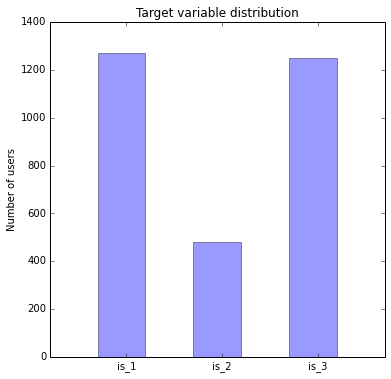

In [56]:
# Compute the distribution of the target variable

counts = [sum(df_users["is_1"]), sum(df_users["is_2"]), sum(df_users["is_3"])]
bins = [0, 1, 2]
print counts

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins, counts, width=0.5, alpha=0.4)
pl.xticks([b + 0.3 for b in bins], ["is_1", "is_2", "is_3"])
pl.xlim(bins[0] - 0.5, bins[-1] + 1)
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того, чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что twitter_id для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря, провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API, прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [57]:
CONSUMER_KEY = "NIdJmEzKanvYMoZMQOLRIWGhu"
CONSUMER_SECRET = "OJVCVs1sG5RxOR1XRn30rj2x5BoPZvPzmSmA8kfLMBr2JjH5yZ"

ACCESS_TOKEN_KEY = "105892440-hiutXI6zWd1XjrQJaotg7GbW6Mt1gihXCnE4njZH"
ACCESS_TOKEN_SECRET = "RxIHlIylRycp8dPZfV8fXSM2WtMP74lteIp5P6jxwh4XW"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничего 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса.

In [58]:
GEO_USER_NAME = "g_o0_stav"

def get_coordinates_by_location(location):    
    response = requests.get("http://api.geonames.org/searchJSON", params={"q": location, "username": GEO_USER_NAME, "maxRows": 1})
    if response.status_code == 200:
        json = response.json()
        if json.get(u"totalResultsCount", 0) > 0:
            geo = json[u"geonames"][0]
            return geo.get("lat"), geo.get("lng"), geo.get("countryName")
        else:
            return None, None, None
    else:
        raise response.raise_for_status()

Следующий шаг -- вызов twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки.

In [59]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

def twitter_user_to_dataframe_record(user):
    record = {
        "twitter_id": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": ts_parser(user.created_at),        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


# Maximum number of user IDs returned by Twitter's user lookup
MAX_USERS_PER_CALL = 100
user_records = []
for i in xrange(len(df_users) / MAX_USERS_PER_CALL):
    lower_ind = i * MAX_USERS_PER_CALL
    upper_ind = min(len(df_users), (i + 1) * MAX_USERS_PER_CALL)
    
    print "Fetching user info batch %d (%d:%d)" % (i, lower_ind, upper_ind - 1)    
    ids = user_id=df_users.iloc[lower_ind:upper_ind]["twitter_id"].tolist()
    for user in api.UsersLookup(user_id=ids):
        user_records.append(twitter_user_to_dataframe_record(user))
    
    sleep_time = api.GetSleepTime("users/search")
    if sleep_time > 0:
        print "Sleeping for %d seconds" % sleep_time
        time.sleep(sleep_time)
        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["twitter_id", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="twitter_id", how="left")
print "Finished building data frame"

Fetching user info batch 0 (0:99)
Fetching user info batch 1 (100:199)
Fetching user info batch 2 (200:299)
Fetching user info batch 3 (300:399)
Fetching user info batch 4 (400:499)
Fetching user info batch 5 (500:599)
Fetching user info batch 6 (600:699)
Fetching user info batch 7 (700:799)
Fetching user info batch 8 (800:899)
Fetching user info batch 9 (900:999)
Fetching user info batch 10 (1000:1099)
Fetching user info batch 11 (1100:1199)
Fetching user info batch 12 (1200:1299)
Fetching user info batch 13 (1300:1399)
Fetching user info batch 14 (1400:1499)
Fetching user info batch 15 (1500:1599)
Fetching user info batch 16 (1600:1699)
Fetching user info batch 17 (1700:1799)
Fetching user info batch 18 (1800:1899)
Fetching user info batch 19 (1900:1999)
Fetching user info batch 20 (2000:2099)
Fetching user info batch 21 (2100:2199)
Fetching user info batch 22 (2200:2299)
Fetching user info batch 23 (2300:2399)
Fetching user info batch 24 (2400:2499)
Fetching user info batch 25 (2500

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://anokhin.github.io/img/hw1_distr.png)).

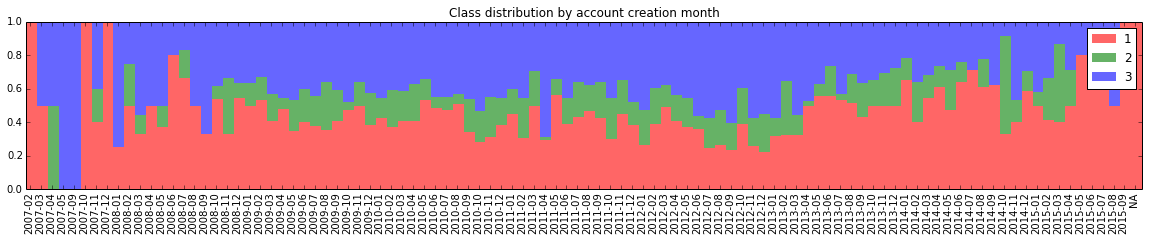

In [61]:
grouped = df_full.groupby(map(lambda dt: dt.strftime("%Y-%m") if pd.notnull(dt) else "NA", df_full["created_at"]))

dts = []
count_1, count_2, count_3 = np.zeros(len(grouped)), np.zeros(len(grouped)), np.zeros(len(grouped))
for i, (dt, group) in enumerate(grouped):
    dts.append(dt)
    count_1[i] = (sum(group["is_1"]))
    count_2[i] = (sum(group["is_2"]))
    count_3[i] = (sum(group["is_3"]))
    
total = (count_1 + count_2 + count_3 + 1e-10)
fraction_1 = count_1 / total
fraction_2 = count_2 / total
fraction_3 = count_3 / total

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_1[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="1")
pl.bar(np.arange(len(dts)), fraction_2[sort_ind], bottom=fraction_1[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="2")
pl.bar(np.arange(len(dts)), fraction_3[sort_ind], bottom=fraction_2[sort_ind] + fraction_1[sort_ind], width=1.0, color='blue', alpha=0.6, linewidth=0, label="3")

pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)).

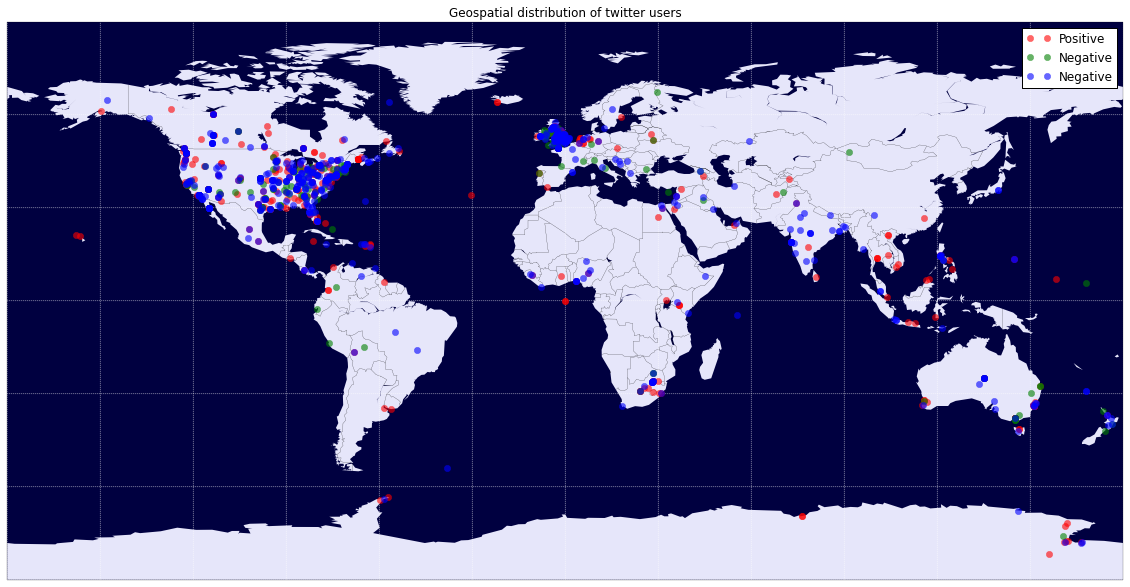

In [63]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(mx, lons, lats, color, label):
    x, y = mx(lons, lats)
    mx.plot(x, y, 'o', markersize=6, color=color, alpha=0.6, markeredgecolor=color, label=label)
    
df_1 = df_full[(df_full["is_1"] == 1) & (pd.notnull(df_full["lat"])) & (pd.notnull(df_full["lon"]))]
plot_points_on_map(m, df_1["lon"], df_1["lat"], 'Red', "Positive")

df_2 = df_full[(df_full["is_2"] == 1) & (pd.notnull(df_full["lat"])) & (pd.notnull(df_full["lon"]))]
plot_points_on_map(m, df_2["lon"], df_2["lat"], 'Green', "Negative")

df_3 = df_full[(df_full["is_3"] == 1) & (pd.notnull(df_full["lat"])) & (pd.notnull(df_full["lon"]))]
plot_points_on_map(m, df_3["lon"], df_3["lat"], 'Blue', "Negative")

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой.

Смотрим на полученный data frame и сохраняем его в .csv файл.

In [65]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,twitter_id,is_1,is_2,is_3,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,66412773,0,0,1,Fred Stevens,TKeep123,"ONLY 18yo+ to follow me! Reality Show Junkie, ...",False,"East of Atlanta, GA",33.74011,-84.34493,United States,2009-08-17 17:04:39+00:00,1607,1940,50190,489,108
1,10143902,0,0,1,Josh Sheldon,joshsheldon,"Dad, MIT App Inventor & STEP Lab teams, educat...",False,"Cambridge, MA",42.3751,-71.10561,United States,2007-11-11 03:52:31+00:00,587,520,1185,42,53
2,73701917,0,0,1,¡¡¡ Bazinga !!!,tulri,Hello. You've reached the house of unrecognize...,False,NaN,NaN,NaN,NaN,2009-09-12 18:23:20+00:00,1124,98,22099,635,25
3,82209363,0,0,1,Sheldon Williams,Shel_Williams9,18 | Anderson CVI | Boxer fighting out of the ...,False,"Ontario, Canada",49.25014,-84.49983,Canada,2009-10-13 22:28:44+00:00,210,254,8038,5537,1
4,47063951,0,0,1,Tony The Weezle,DopeWeezle,Im just a Material boy living in a Material wo...,False,Las Vegas,36.17497,-115.13722,United States,2009-06-14 09:17:23+00:00,1737,1691,15121,23345,20
